In [1]:
import os
print(os.path.exists("cube.obj")) 

True


In [2]:
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
import colorsys

mi.set_variant('scalar_rgb')

def light_grid(face, n1, n2, const_val, scale=1.0):
    half = scale / 2
    positions = []

    if face == "top":
        xs = np.linspace(-half, half, n1)
        zs = np.linspace(-half, half, n2)
        for x in xs:
            for z in zs:
                positions.append((face, [x, const_val, z]))

    elif face == "back":
        xs = np.linspace(-half, half, n1)
        ys = np.linspace(-half, half, n2)
        for x in xs:
            for y in ys:
                positions.append((face, [x, y, const_val]))

    elif face == "left" or face == "right":
        ys = np.linspace(-half, half, n1)
        zs = np.linspace(-half, half, n2)
        for y in ys:
            for z in zs:
                positions.append((face, [const_val, y, z]))

    return positions

def rainbow(i, total):
    hue = i / total
    saturation = 1.0
    value = 1.0
    r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
    # return [r * 1.5, g * 1.5, b * 1.5]
    return [r, g, b]



[mitsuba] Warning: Couldn't import the ipywidgets package. Installing this package is required for the system to properly log messages and print in Jupyter notebooks!


In [3]:
import json

configs = json.load(open("color_configs.json"))
print(configs.keys())

dict_keys(['RGB', 'CMYK', 'GRAY', 'WHITE', 'WARM', 'COOL', 'RAINBOW', 'NEON', 'PASTEL', 'SIDES', 'TOP'])


In [11]:
def get_light_color(face, config_name):
     with open('color_configs.json') as f:
          color_configs = json.load(f)

     if config_name not in color_configs:
          raise ValueError(f"Configuration '{config_name}' not found in color_configs.json")
     config = color_configs[config_name]

     color = config.get(face, [0, 0, 0])

     return color

In [ ]:
# TODO: transform cube and light grid depending on parameters

def transform_scene(x, y, z, s, x_r, y_r, z_r, config='WHITE'):
    cube_transform = (
        mi.ScalarTransform4f()
        .translate([x, y, z])
        .rotate([1, 0, 0], x_r)
        .rotate([0, 1, 0], y_r)
        .rotate([0, 0, 1], z_r)
        .scale(s)
    )

    # 10 x 15 = 150 lights
    top_pos   = light_grid("top",   10, 15,  s/2, s)   
    back_pos  = light_grid("back",  10, 15, -s/2, s)  
    left_pos  = light_grid("left",  10, 15, -s/2, s)  
    right_pos = light_grid("right", 10, 15,  s/2, s)   

    all_pos = top_pos + back_pos + left_pos + right_pos

    # transformed = []
    # for face, pos in all_pos:
    #     p_local = mi.Point3f(pos)
    #     p_world = cube_transform @ p_local
    #     transformed.append((face, [float(p_world[0]), float(p_world[1]), float(p_world[2])]))
    num_emitters = len(all_pos)
    print(f"Number of emitters: {num_emitters}")
    emitters = {}

    for i, (face, pos) in enumerate(all_pos):
        color = get_light_color(face, config)
        world_pos = cube_transform @ mi.Point3f(pos)
        emitters[f"light_{i}"] = {
            "type": "point",
            "position": [float(world_pos[0]), float(world_pos[1]), float(world_pos[2])],
            "intensity": {
                "type": "rgb",
                "value": color
            }
        }

    walls = {}

    def rectangle_wall(name, local_tf, flip=False):
        wall = {
            "type": "rectangle",
            "to_world": cube_transform @ local_tf,
        "bsdf": {
            "type": "twosided",
            "nested": {
                "type": "diffuse",
                "reflectance": {"type": "rgb", "value": [0.2, 0.2, 0.2]}
            }
        }

        }
        if flip:
            wall["flip_normals"] = True
        walls[name] = wall

    rectangle_wall("cube-back",   mi.ScalarTransform4f().translate([0,  0.5, 0]).rotate([1,0,0], 90))
    rectangle_wall("cube-left",   mi.ScalarTransform4f().translate([-0.5, 0, 0]).rotate([0,1,0], 90))
    rectangle_wall("cube-right",  mi.ScalarTransform4f().translate([ 0.5, 0, 0]).rotate([0,1,0], -90))
    rectangle_wall("cube-top",    mi.ScalarTransform4f().translate([0, 0, 0.5]), flip=True)
    rectangle_wall("cube-bottom", mi.ScalarTransform4f().translate([0, 0, -0.5]))


    return walls, emitters

Number of emitters: 600


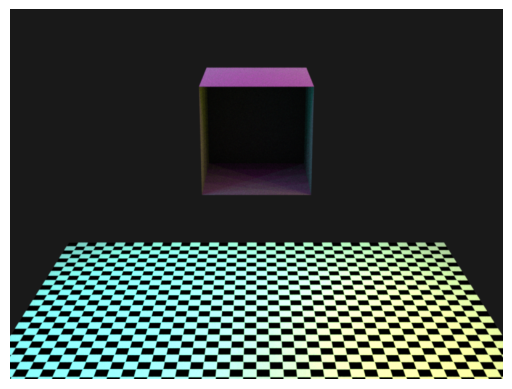

In [40]:
import json

CONFIG = 'NEON'
walls, emitters = transform_scene(0, 2, 0, 3, 90, 0, 180, CONFIG)

scene_dict = {
    "type": "scene",
    "integrator": {"type": "path"},
    "sensor": {
        "type": "perspective",
        "sampler": {"type": "independent", "sample_count": 512},
        "to_world": mi.ScalarTransform4f().look_at(
            origin=[0, 7, 20], target=[0, 0, 0], up=[0, 1, 0]
        ),
        "film": {
            "type": "hdrfilm",
            "width": 800,
            "height": 600,
            "pixel_format": "rgb"
        },
    },
    "env": {
        "type": "constant",
        "radiance": {"type": "rgb", "value": [0.01, 0.01, 0.01]}
    },
    # Leave out the hardcoded cube-* here
    "checkerboard": {
        "type": "rectangle",
        "to_world": mi.ScalarTransform4f()
            .translate([0, -5, 0])
            .rotate([1, 0, 0], -90)
            .scale([8, 8, 1]),
        "bsdf": {
            "type": "diffuse",
            "reflectance": {
                "type": "checkerboard",
                "color0": {"type": "rgb", "value": [1.0, 1.0, 1.0]},
                "color1": {"type": "rgb", "value": [0.0, 0.0, 0.0]},
                "to_uv": mi.Transform4f().scale(mi.Vector3f(20, 20, 1))
            }
        }
    }
}


scene_dict.update(walls)
scene_dict.update(emitters)

scene = mi.load_dict(scene_dict)
img = mi.render(scene)
plt.imshow(mi.util.convert_to_bitmap(img))
plt.axis('off')
plt.savefig(f"output/{CONFIG}_t.png", dpi=300, bbox_inches='tight')
# plt.show()
